In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries:

In [2]:
# basic tools:

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


In [53]:
# supervised learning tools and models:

# sklearn tools:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, f1_score


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
np.random.seed(42)


Load in data:

In [54]:
#X2 = pd.read_csv('../data/working_files/X2.csv')
X2 = pd.read_csv('/content/drive/MyDrive/DSI/geocaching/data/X2.csv')
#df = pd.read_csv('../data/working_files/cleaned_data.csv')
df = pd.read_csv('/content/drive/MyDrive/DSI/geocaching/data/cleaned_data.csv')

### Prepare X and y:

I will try supervised classification models to predict fav_points (as binary), using:
1. Numerical and dummy/binary data only
2. Numerical, dummy/binary + sentiment of logs
3. Cache text only
4. Numerical, dummy/binary + sentiment of logs + binary for KEY words


In [55]:
# y:
df['fav_points_binary'] = [1 if f>1 else 0 for f in list(df['fav_points'])]

y = df['fav_points_binary']
y.value_counts(normalize=True)


0    0.518781
1    0.481219
Name: fav_points_binary, dtype: float64

In [56]:
X2_dilute = X2.copy()
X2_dilute = X2_dilute[['difficulty',
       'terrain', 'size', 'status', 'is_premium',
       'short_description', 'long_description', 'hints', 'travel_bugs', 'cache_type_Earth',
       'cache_type_Event', 'cache_type_Letterbox',
       'cache_type_Lost and Found Event', 'cache_type_Maze Exhibit',
       'cache_type_Mega event', 'cache_type_Multi', 'cache_type_Traditional',
       'cache_type_Unknown/Mystery', 'cache_type_Virtual', 'cache_type_Webcam',
       'cache_type_Wherigo']]
X_train, X_test, y_train, y_test = train_test_split(X2_dilute,y, test_size=0.2, random_state=42, stratify=y)


In [57]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
X_train.shape[1]

21

In [58]:
model = Sequential()

model.add(Dense(256, activation = 'relu', input_shape = (X_train.shape[1],)))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))

model.add(Dense(1, activation = 'sigmoid'))

stop = EarlyStopping(monitor = 'val_loss', patience = 3)

#compile the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['Precision'])

# fit the model
results = model.fit(X_train_sc, y_train,
                    batch_size = 100,
                    epochs = 40, 
                    validation_data = (X_test_sc, y_test),
                    callbacks = stop,
                    verbose = 1)

Epoch 1/40
100/100 [==============================] - 2s 11ms/step - loss: 0.6429 - precision: 0.5980 - val_loss: 0.5925 - val_precision: 0.7122
Epoch 2/40
100/100 [==============================] - 1s 8ms/step - loss: 0.5773 - precision: 0.7010 - val_loss: 0.5837 - val_precision: 0.6882
Epoch 3/40
100/100 [==============================] - 1s 8ms/step - loss: 0.5758 - precision: 0.6958 - val_loss: 0.5753 - val_precision: 0.6817
Epoch 4/40
100/100 [==============================] - 1s 8ms/step - loss: 0.5730 - precision: 0.7058 - val_loss: 0.5727 - val_precision: 0.6921
Epoch 5/40
100/100 [==============================] - 1s 8ms/step - loss: 0.5671 - precision: 0.7144 - val_loss: 0.5726 - val_precision: 0.7153
Epoch 6/40
100/100 [==============================] - 1s 8ms/step - loss: 0.5641 - precision: 0.7229 - val_loss: 0.5771 - val_precision: 0.7068
Epoch 7/40
100/100 [==============================] - 1s 9ms/step - loss: 0.5646 - precision: 0.7148 - val_loss: 0.5749 - val_precision

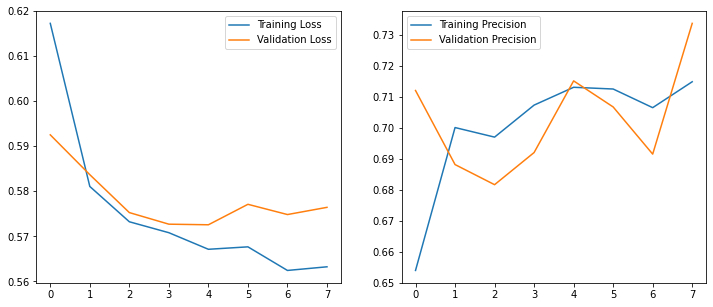

In [59]:
fig = plt.figure(figsize=(12,5));
ax = fig.add_subplot(121);
plt.plot(results.history['loss'], label='Training Loss');
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.legend();
ax = fig.add_subplot(122);
plt.plot(results.history['precision'], label='Training Precision');
plt.plot(results.history['val_precision'], label='Validation Precision')
plt.legend();

In [60]:
predictions = model.predict(X_test_sc)
bin_predictions = tf.round(predictions).numpy().flatten()
bin_predictions

array([1., 1., 1., ..., 0., 1., 0.], dtype=float32)

In [61]:
print(classification_report(y_test, bin_predictions));

cm = confusion_matrix(y_test,bin_predictions)
acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
rec = cm[1][1]/(cm[1][1] + cm[1][0])
prc = cm[1][1]/(cm[1][1] + cm[0][1])
f1  = 2*prc*rec/(prc+rec)


              precision    recall  f1-score   support

           0       0.68      0.80      0.73      1290
           1       0.73      0.59      0.65      1197

    accuracy                           0.70      2487
   macro avg       0.71      0.70      0.69      2487
weighted avg       0.70      0.70      0.70      2487



In [62]:
print(f'RF accuracy  = 0.695215, NN accuracy  = {acc}')	
print(f'RF recall    = 0.582289, NN recall    = {rec}')
print(f'RF precision = 0.729843, NN precision = {prc}')
print(f'RF f1-score  = 0.647770, NN f1-score  = {f1}')

RF accuracy  = 0.695215, NN accuracy  = 0.6996381182147166
RF recall    = 0.582289, NN recall    = 0.5898078529657477
RF precision = 0.729843, NN precision = 0.7338877338877339
RF f1-score  = 0.647770, NN f1-score  = 0.6540064844835571


In [73]:
model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 256)               5632      
_________________________________________________________________
dense_93 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_94 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_95 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_96 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_97 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_98 (Dense)             (None, 64)              

This is very marginal improvement. I will stick with the random forest model for my app.